In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl

from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, classification_report, accuracy_score, confusion_matrix, roc_curve, roc_auc_score
from sklearn.feature_selection import VarianceThreshold
from sklearn.pipeline import Pipeline
from sklearn.calibration import CalibrationDisplay

In [2]:
wego = pd.read_csv('data/wego_ml.csv')
wego.head()

,ID,CALENDAR_ID,SERVICE_ABBR,ADHERENCE_ID,DATE,ROUTE_ABBR,BLOCK_ABBR,OPERATOR,TRIP_ID,OVERLOAD_ID,...,ADJUSTED_ONTIME_COUNT,STOP_CANCELLED,PREV_SCHED_STOP_CANCELLED,IS_RELIEF,BLOCK_STOP_ORDER,DWELL_IN_MINS,NextDay_Scheduled,NextDay_Actual_Arrival,NextDay_Actual_Departure,STARTING_ADHERENCE
0,120230801_345104,120230801,1,99457892,2023-08-01,22,2200,1040,345104,0,...,1,0,0.0,0,19,0.0,0,0,0,-2.133333
1,120230801_345105,120230801,1,99457895,2023-08-01,22,2200,1040,345105,0,...,1,0,0.0,0,51,0.0,0,0,0,-1.583333
2,120230801_345106,120230801,1,99457899,2023-08-01,22,2200,1040,345106,0,...,1,0,0.0,0,80,0.0,0,0,0,-1.716666
3,120230801_345107,120230801,1,99457902,2023-08-01,22,2200,1040,345107,0,...,0,0,0.0,0,112,0.0,0,0,0,-1.316666
4,120230801_345108,120230801,1,99457906,2023-08-01,22,2200,1040,345108,0,...,1,0,0.0,0,141,0.0,0,0,0,-1.516666


In [3]:
logreg = LogisticRegression()

1. Create a new (target) variable, ON-TIME. We'll consider a trip to be on-time is it is no more than 6 minutes late (ADHERENCE >= -6) and is  no more than 1 minute early (ADHERENCE <= 1).

In [4]:
wego['ON-TIME'] = np.where((wego['ADHERENCE']<=1) & (wego['ADHERENCE']>=-6), True, False)
wego.head()

,ID,CALENDAR_ID,SERVICE_ABBR,ADHERENCE_ID,DATE,ROUTE_ABBR,BLOCK_ABBR,OPERATOR,TRIP_ID,OVERLOAD_ID,...,STOP_CANCELLED,PREV_SCHED_STOP_CANCELLED,IS_RELIEF,BLOCK_STOP_ORDER,DWELL_IN_MINS,NextDay_Scheduled,NextDay_Actual_Arrival,NextDay_Actual_Departure,STARTING_ADHERENCE,ON-TIME
0,120230801_345104,120230801,1,99457892,2023-08-01,22,2200,1040,345104,0,...,0,0.0,0,19,0.0,0,0,0,-2.133333,True
1,120230801_345105,120230801,1,99457895,2023-08-01,22,2200,1040,345105,0,...,0,0.0,0,51,0.0,0,0,0,-1.583333,True
2,120230801_345106,120230801,1,99457899,2023-08-01,22,2200,1040,345106,0,...,0,0.0,0,80,0.0,0,0,0,-1.716666,True
3,120230801_345107,120230801,1,99457902,2023-08-01,22,2200,1040,345107,0,...,0,0.0,0,112,0.0,0,0,0,-1.316666,False
4,120230801_345108,120230801,1,99457906,2023-08-01,22,2200,1040,345108,0,...,0,0.0,0,141,0.0,0,0,0,-1.516666,True


In [5]:
# conditions  = [ wego['ADHERENCE'] > 1, (wego['ADHERENCE'] <= 1) & (wego['ADHERENCE'] >= -6), wego['ADHERENCE'] <= -6]
# choices     = [ "Early", 'On Time', 'Late' ]
# wego['ON-TIME'] = np.select(conditions, choices, default='')

# wego.head()

2. Fit a logistic regression model predicting the ADHERENCE using the ROUTE_ABBR and ROUTE_DIRECTION_NAME columns. How accurate is this model? How does it do in terms of precition and recall? What about ROC-AUC and calibration?

In [6]:
predictorsq2 = ['ROUTE_ABBR', 'ROUTE_DIRECTION_NAME']
categorical_predictorsq2 = ['ROUTE_ABBR', 'ROUTE_DIRECTION_NAME']

Xq2 = wego[predictorsq2]
Xq2 = pd.get_dummies(Xq2, columns = categorical_predictorsq2, drop_first= True)
yq2 = wego['ON-TIME']

In [7]:
X_trainq2, X_testq2, y_trainq2, y_testq2 = train_test_split(Xq2, yq2, random_state = 321)

In [8]:
logregq2 = logreg.fit(X_trainq2, y_trainq2)
y_predq2 = logregq2.predict(X_testq2)

In [9]:
logregq2.intercept_

array([0.56742728])

In [10]:
logregq2.coef_

array([[ 0.15720158,  0.85099447,  0.67752229,  0.49006587, -0.0009801 ,
        -0.55183018,  0.06320692,  0.59228707]])

In [11]:
boundary = - logregq2.intercept_[0] / logregq2.coef_[0]
boundary

array([ -3.60955196,  -0.6667814 ,  -0.83750349,  -1.15785921,
       578.94998876,   1.02826432,  -8.97729641,  -0.95802747])

In [12]:
print(f'The accuracy score using route_abbr and route_direction_name as logreg predictors is: {accuracy_score(y_testq2, y_predq2):.3f}')

The accuracy score using route_abbr and route_direction_name as logreg predictors is: 0.729


In [13]:
print(classification_report(y_testq2, logreg.predict(X_testq2)))

              precision    recall  f1-score   support

       False       0.00      0.00      0.00      4355
        True       0.73      1.00      0.84     11729

    accuracy                           0.73     16084
   macro avg       0.36      0.50      0.42     16084
weighted avg       0.53      0.73      0.62     16084



C:\ProgramData\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\ProgramData\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\ProgramData\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [14]:
print(confusion_matrix(y_testq2, logreg.predict(X_testq2)))

[[    0  4355]
 [    0 11729]]


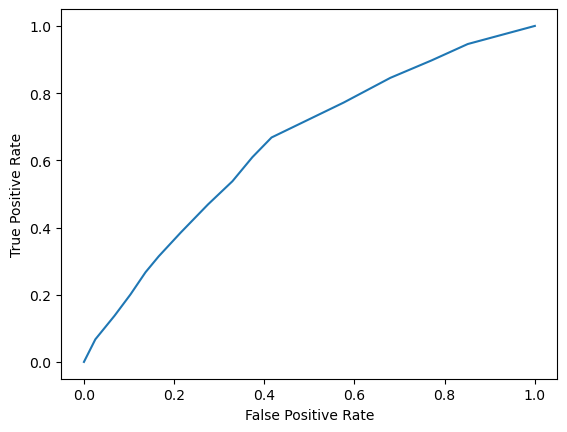

In [15]:
fpr, tpr, thresholds = roc_curve(y_testq2, logreg.predict_proba(X_testq2)[:,1])
plt.plot(fpr, tpr)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate');

In [16]:
roc_auc_score(y_testq2, logreg.predict_proba(X_testq2)[:,1])

0.6474782837323446

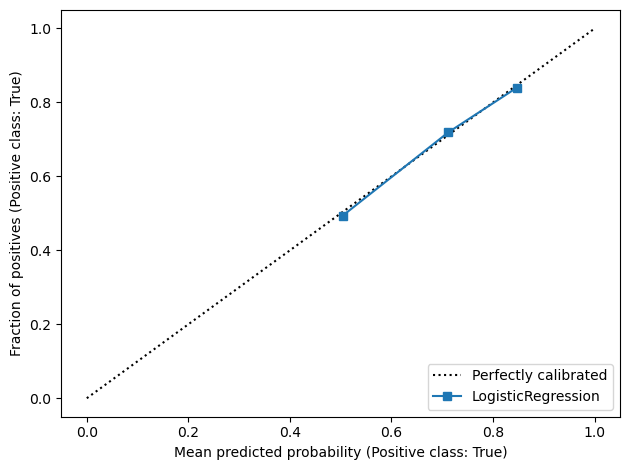

In [17]:
CalibrationDisplay.from_estimator(logregq2, X_testq2, y_testq2)
plt.tight_layout()
#plt.savefig('images/calibration_curve.png');

3. Now, try using the ROUTE_ABBR, ROUTE_DIRECTION_NAME, and OPERATOR. Does this improve the model? Note: you may need to increase the max_iter parameter of your model in order for it to converge.

In [18]:
predictorsq3 = ['ROUTE_ABBR', 'ROUTE_DIRECTION_NAME', 'OPERATOR']
categorical_predictorsq3 = ['ROUTE_ABBR', 'ROUTE_DIRECTION_NAME', 'OPERATOR']
operators = wego['OPERATOR'].value_counts()[lambda x: x> 50].index.tolist()

Xq3 = wego[predictorsq3]
Xq3.loc[~Xq3['OPERATOR'].isin(operators), 'OPERATOR'] = 999999
Xq3 = pd.get_dummies(Xq3, columns = categorical_predictorsq3, drop_first= True)

yq3 = wego['ON-TIME']

In [19]:
X_trainq3, X_testq3, y_trainq3, y_testq3 = train_test_split(Xq3, yq3, random_state = 321)

In [20]:
logregq3 = logreg.fit(X_trainq3, y_trainq3)
y_predq3 = logregq3.predict(X_testq3)

C:\ProgramData\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [21]:
logregq3.intercept_

array([0.64811687])

In [22]:
logregq3.coef_

array([[ 2.00379061e-01,  8.20695393e-01,  6.09185600e-01,
         4.51924743e-01,  1.15482615e-01, -5.50543557e-01,
         1.44407129e-01,  6.23856714e-01,  6.96887962e-02,
         7.72648169e-01, -5.34994637e-01,  5.96886809e-01,
        -1.19125799e+00, -4.85999124e-01,  1.08536417e+00,
         1.52568849e+00,  7.23311749e-02, -5.58431072e-02,
         5.93868752e-01, -2.76397588e-01,  1.72352182e+00,
         7.03637203e-02, -2.36344545e-01,  7.04146438e-01,
         6.06559513e-01, -7.09727785e-01,  1.20143886e+00,
        -8.85859377e-02, -2.93655427e-01, -7.30624338e-01,
         4.02812417e-01,  9.39104450e-01,  9.72763428e-01,
         2.46498703e-01,  1.35060776e-01,  2.09054105e-01,
        -1.99430293e-01,  3.06947453e-01,  1.28510951e-01,
        -7.27760149e-01, -4.11025545e-01,  1.17322707e+00,
        -5.80755064e-01, -5.54517661e-01, -5.09064346e-02,
        -1.05560293e-01, -1.10770055e+00,  6.01962595e-01,
         1.62641614e-01,  3.48287533e-01, -1.34653018e+0

In [23]:
boundary = - logregq3.intercept_[0] / logregq3.coef_[0]
boundary

array([-3.23445409e+00, -7.89716720e-01, -1.06390708e+00, -1.43412567e+00,
       -5.61224625e+00,  1.17723088e+00, -4.48812242e+00, -1.03888739e+00,
       -9.30015885e+00, -8.38825354e-01,  1.21144555e+00, -1.08582878e+00,
        5.44060884e-01,  1.33357622e+00, -5.97142317e-01, -4.24802886e-01,
       -8.96040850e+00,  1.16060317e+01, -1.09134699e+00,  2.34487167e+00,
       -3.76042164e-01, -9.21095234e+00,  2.74225442e+00, -9.20429103e-01,
       -1.06851325e+00,  9.13190787e-01, -5.39450569e-01,  7.31625009e+00,
        2.20706588e+00,  8.87072659e-01, -1.60897938e+00, -6.90143545e-01,
       -6.66263611e-01, -2.62929122e+00, -4.79870540e+00, -3.10023510e+00,
        3.24984166e+00, -2.11149129e+00, -5.04328128e+00,  8.90563842e-01,
        1.57682870e+00, -5.52422365e-01,  1.11599005e+00,  1.16879393e+00,
        1.27315315e+01,  6.13977904e+00,  5.85101157e-01, -1.07667300e+00,
       -3.98493877e+00, -1.86086728e+00,  4.81323688e-01,  8.88218936e-01,
       -1.08794049e+00, -

In [24]:
print(f'The accuracy score using route_abbr, route_direction_name, and operator as logreg predictors is: {accuracy_score(y_testq3, y_predq3):.3f}')

The accuracy score using route_abbr, route_direction_name, and operator as logreg predictors is: 0.747


In [25]:
print(classification_report(y_testq3, logreg.predict(X_testq3)))

              precision    recall  f1-score   support

       False       0.59      0.21      0.31      4355
        True       0.76      0.95      0.85     11729

    accuracy                           0.75     16084
   macro avg       0.68      0.58      0.58     16084
weighted avg       0.72      0.75      0.70     16084



In [26]:
print(confusion_matrix(y_testq3, logreg.predict(X_testq3)))

[[  928  3427]
 [  639 11090]]


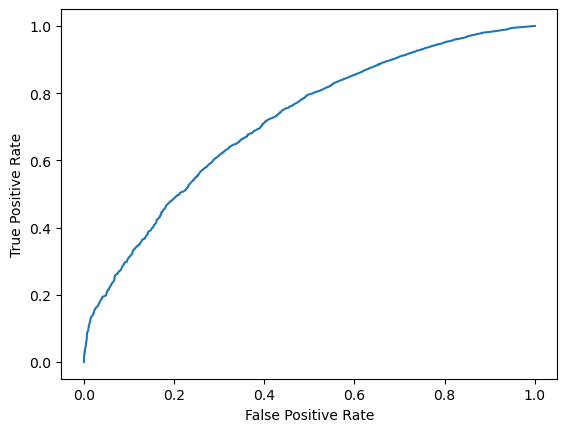

In [27]:
fpr, tpr, thresholds = roc_curve(y_testq3, logreg.predict_proba(X_testq3)[:,1])
plt.plot(fpr, tpr)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate');

In [28]:
roc_auc_score(y_testq3, logreg.predict_proba(X_testq3)[:,1])

0.7167602669509539

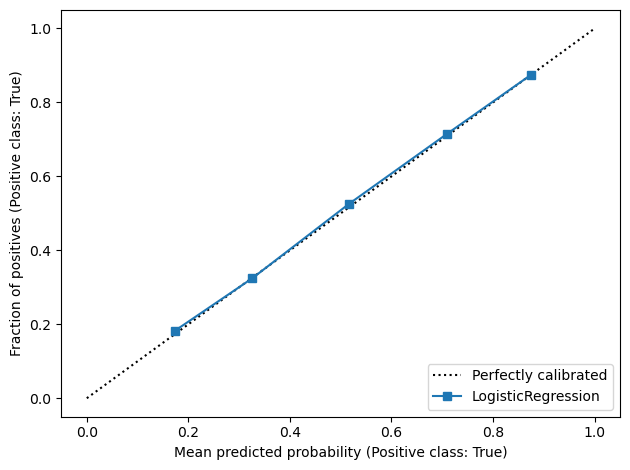

In [29]:
CalibrationDisplay.from_estimator(logregq3, X_testq3, y_testq3)
plt.tight_layout()
#plt.savefig('images/calibration_curve.png');

4. Finally, the data you have been provided has an STARTING_ADHERENCE column, which contains the ADHERENCE at the beginning of the route. If you add this metric, does it improve the model?

In [30]:
predictorsq4 = ['ROUTE_ABBR', 'ROUTE_DIRECTION_NAME', 'OPERATOR', 'STARTING_ADHERENCE']
categorical_predictorsq4 = ['ROUTE_ABBR', 'ROUTE_DIRECTION_NAME', 'OPERATOR']
operators = wego['OPERATOR'].value_counts()[lambda x: x> 50].index.tolist()

Xq4 = wego[predictorsq4]
Xq4.loc[~Xq4['OPERATOR'].isin(operators), 'OPERATOR'] = 999999
Xq4 = pd.get_dummies(Xq4, columns = categorical_predictorsq4, drop_first= True)
yq4 = wego['ON-TIME']

In [31]:
X_trainq4, X_testq4, y_trainq4, y_testq4 = train_test_split(Xq4, yq4, random_state = 321)

In [32]:
logregq4 = logreg.fit(X_trainq4, y_trainq4)
y_predq4 = logregq4.predict(X_testq4)

C:\ProgramData\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [33]:
logregq4.intercept_

array([1.26176861])

In [34]:
logregq4.coef_

array([[ 2.03978536e-01,  1.36792092e-01,  6.93395322e-01,
         4.65636426e-01,  5.33621068e-01,  1.08915285e-01,
        -5.14728559e-01,  5.88834169e-02,  4.81711959e-01,
         3.51928822e-01,  4.76070743e-01, -3.63548829e-01,
         3.51748883e-01, -8.37326054e-01, -4.91465564e-01,
         1.09332237e+00,  1.50998739e+00,  9.40246659e-02,
        -1.29849404e-01,  4.29313821e-01, -3.10079360e-01,
         1.53090778e+00,  1.39006956e-01, -8.62991454e-03,
         6.65194199e-01,  6.35069671e-01, -9.71631872e-01,
         8.97399020e-01, -1.64950207e-01, -4.96922503e-01,
        -5.77288932e-01,  2.72150916e-01,  9.98073066e-01,
         6.99668698e-01,  4.03300807e-01,  1.75958671e-01,
         1.34317404e-01, -1.83660347e-03,  5.44984082e-01,
         1.53528461e-01, -4.29338068e-01, -4.10498124e-01,
         9.30629687e-01, -2.31276223e-01, -3.93326515e-01,
        -4.73370553e-02, -2.58277252e-01, -7.73182394e-01,
         5.65529658e-01,  1.13112218e-01,  3.63933754e-0

In [35]:
boundary = - logregq4.intercept_[0] / logregq4.coef_[0]
boundary

array([-6.18579109e+00, -9.22398797e+00, -1.81969588e+00, -2.70977214e+00,
       -2.36454047e+00, -1.15848626e+01,  2.45132816e+00, -2.14282505e+01,
       -2.61934251e+00, -3.58529490e+00, -2.65038050e+00,  3.47069914e+00,
       -3.58712898e+00,  1.50690236e+00,  2.56735915e+00, -1.15406823e+00,
       -8.35615332e-01, -1.34195490e+01,  9.71716909e+00, -2.93903562e+00,
        4.06917961e+00, -8.24196353e-01, -9.07701777e+00,  1.46208703e+02,
       -1.89684248e+00, -1.98681919e+00,  1.29860768e+00, -1.40602851e+00,
        7.64939091e+00,  2.53916577e+00,  2.18567955e+00, -4.63628280e+00,
       -1.26420465e+00, -1.80338011e+00, -3.12860423e+00, -7.17082372e+00,
       -9.39393239e+00,  6.87011993e+02, -2.31523938e+00, -8.21846716e+00,
        2.93886964e+00,  3.07375001e+00, -1.35582244e+00,  5.45567804e+00,
        3.20794191e+00,  2.66549874e+01,  4.88532614e+00,  1.63191586e+00,
       -2.23112722e+00, -1.11550161e+01, -3.46702826e+00,  9.01660301e-01,
        2.26068915e+00, -

In [36]:
print(f'The accuracy score using route_abbr, route_direction_name, operator, and starting adherence as logreg predictors is: {accuracy_score(y_testq4, y_predq4):.3f}')

The accuracy score using route_abbr, route_direction_name, operator, and starting adherence as logreg predictors is: 0.782


In [37]:
print(classification_report(y_testq4, logreg.predict(X_testq4)))

              precision    recall  f1-score   support

       False       0.72      0.32      0.44      4355
        True       0.79      0.95      0.86     11729

    accuracy                           0.78     16084
   macro avg       0.76      0.64      0.65     16084
weighted avg       0.77      0.78      0.75     16084



In [38]:
print(confusion_matrix(y_testq4, logreg.predict(X_testq4)))

[[ 1396  2959]
 [  543 11186]]


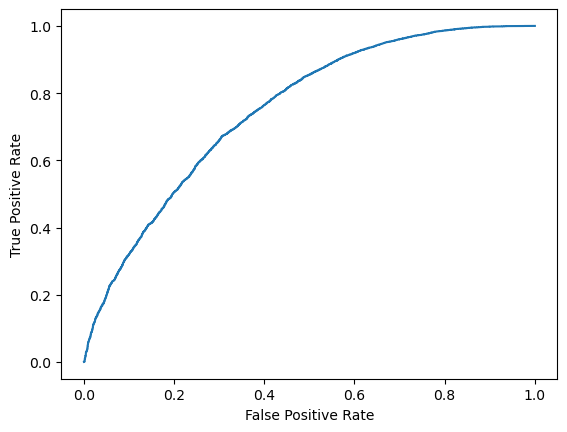

In [39]:
fpr, tpr, thresholds = roc_curve(y_testq4, logreg.predict_proba(X_testq4)[:,1])
plt.plot(fpr, tpr)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate');

In [40]:
roc_auc_score(y_testq4, logreg.predict_proba(X_testq4)[:,1])

0.7509769469513337

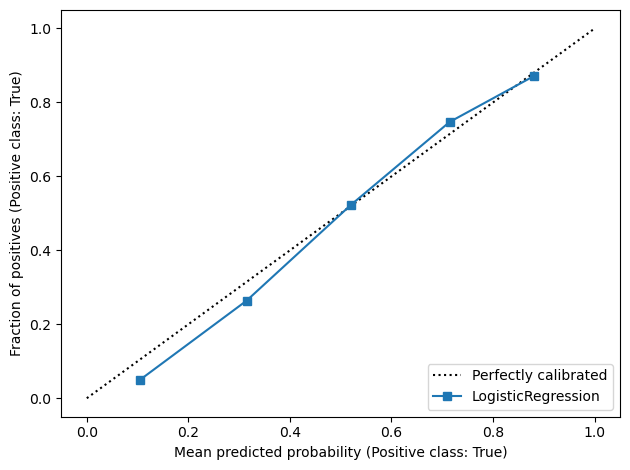

In [41]:
CalibrationDisplay.from_estimator(logregq4, X_testq4, y_testq4)
plt.tight_layout()
#plt.savefig('images/calibration_curve.png');